- 데이터 파일(힙 테이블, 인덱스, 여유 공간 맵, 가시성 맵) 내에서는 기본적으로 8192바이트(8KB)인 고정 길이의 페이지 (또는 블록)로 나뉨.
- 각 파일 내의 페이지에는 0부터 순차적으로 번호가 매겨지며, 이 번호를 블록 번호 라고 함.
- 파일이 꽉 차면 PostgreSQL은 파일 끝에 새로운 빈 페이지를 추가하여 파일 크기를 늘림.
- 페이지의 내부 레이아웃은 데이터 파일 유형에 따라 다름.

**힙 테이블 파일의 페이지 레이아웃**

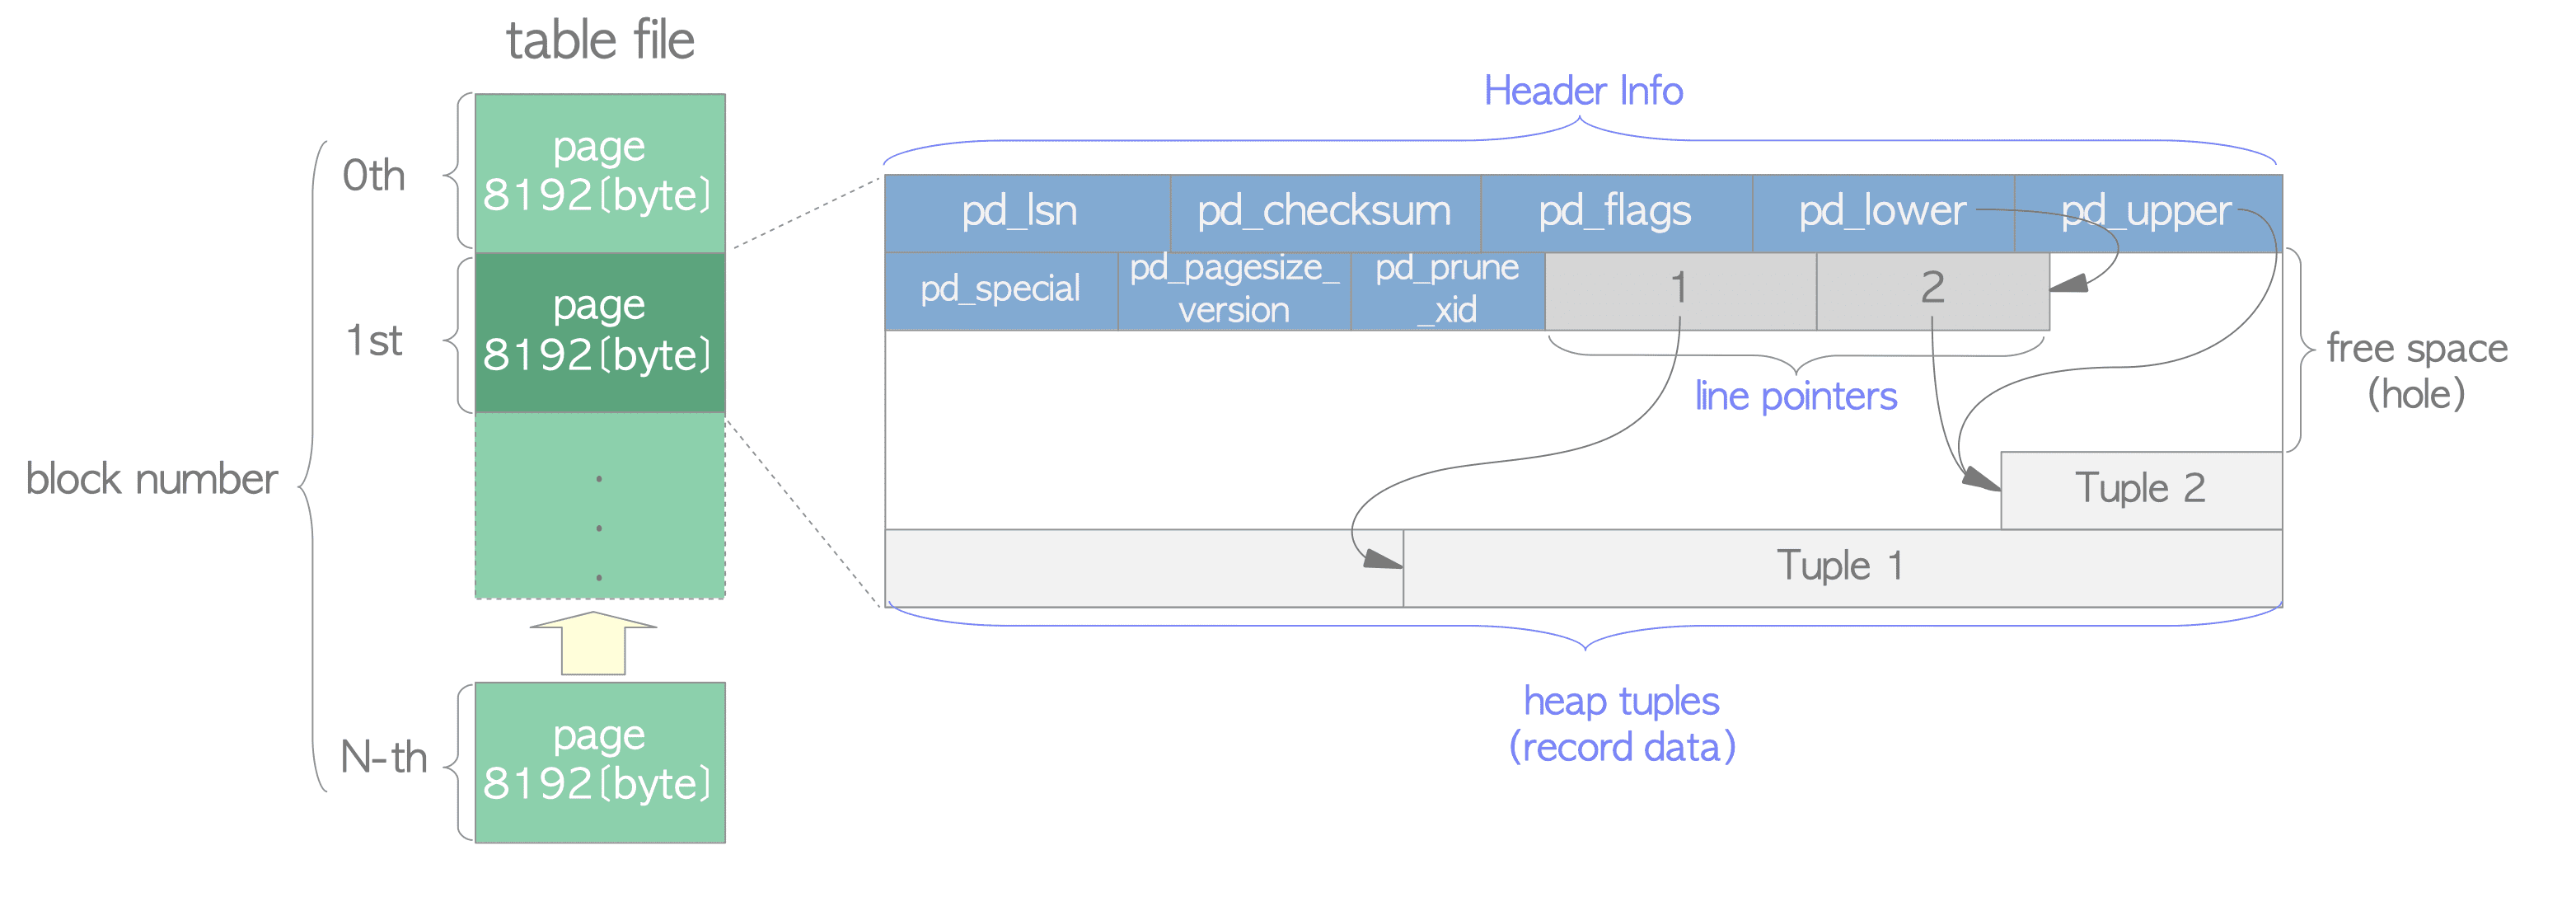

**테이블 내의 페이지에는 세 가지 종류의 데이터가 포함**.

**힙 튜플**
- 힙 튜플은 레코드 데이터 자체.
  - 힙 튜플은 페이지 하단부터 순서대로 쌓임.
- 튜플의 내부 구조는 PostgreSQL의 CC(동시성 제어)와 WAL(미리 쓰기 로깅)에 대한 지식이 필요

**라인 포인터**
- 라인 포인터는 길이가 4바이트이며 각 힙 튜플에 대한 포인터를 보유.
  - 항목 포인터 라고도 함.
- 라인 포인터는 튜플에 대한 인덱스 역할을 하는 간단한 배열을 형성.
- 각 인덱스는 1부터 순차적으로 번호가 지정되며 오프셋 번호라고 함.
- 새 튜플이 페이지에 추가되면 새 라인 포인터도 배열에 푸시되어 새 튜플을 가리킴.

**헤더 데이터**
- PageHeaderData 구조로 정의된 헤더 데이터는 페이지 시작 부분에 할당됨.
- 길이는 24바이트이며 페이지에 대한 일반 정보를 포함.



**구조의 주요 변수**

```
typedef struct PageHeaderData @src/include/storage/bufpage.h
{
  /* XXX LSN is member of *any* block, not only page-organized ones */
  PageXLogRecPtr       pd_lsn;      /* LSN: next byte after last byte of xlog
  		       		     * record for last change to this page */
  uint16        	pd_checksum; /* checksum */
  uint16        	pd_flags;    /* flag bits, see below */
  LocationIndex 	pd_lower;    /* offset to start of free space */
  LocationIndex 	pd_upper;    /* offset to end of free space */
  LocationIndex 	pd_special;  /* offset to start of special space */
  uint16        	pd_pagesize_version;
  TransactionId 	pd_prune_xid;/* oldest prunable XID, or zero if none */
  ItemIdData    	pd_linp[1];  /* beginning of line pointer array */
} PageHeaderData;

typedef PageHeaderData *PageHeader;

typedef uint64 XLogRecPtr;
```

**pd_lsn**
- 이 변수는 이 페이지의 마지막 변경으로 작성된 XLOG 레코드의 LSN을 저장.
- 8바이트의 부호 없는 정수이며 WAL(Write-Ahead Logging) 메커니즘과 관련.

**pd_checksum**
- 이 변수는 이 페이지의 체크섬 값을 저장. (이 변수는 9.3 버전 이상에서 지원. 이전 버전에서는 이 부분에 페이지의 timelineId가 저장되어 있었음.)

**pd_lower, pd_upper**
- pd_lower는 라인 포인터의 끝을 가리키고, pd_upper는 최신 힙 튜플의 시작을 가리킴.

**pd_special**
- 이 변수는 인덱스용.
- 테이블 내의 페이지에서는 페이지의 끝을 가리킴. (인덱스 내의 페이지에서는 인덱스만이 가지는 데이터 영역으로 B-tree, GiST, GiN 등 인덱스 종류에 따라 특정 데이터를 담고 있는 특수 공간의 시작을 가리킴.)

- 라인 포인터의 끝과 최신 튜플의 시작 사이의 빈 공간을 여유 공간 또는 구멍 이라고 함 .

- 테이블 내의 튜플을 식별하기 위해 TID(튜플 식별자)가 내부적으로 사용.
- TID는 한 쌍의 값, 즉 튜플을 포함하는 페이지의 블록 번호 와 튜플을 가리키는 라인 포인터의 오프셋 번호 로 구성.
  - 일반적인 사용법의 예는 index


- 크기가 약 2KB(8KB의 약 1/4)보다 큰 힙 튜플은 TOAST (The Overised-Attribute Storage Technique)라는 방법을 사용하여 저장 및 관리